In [1]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator
import os,time
from scipy.io import loadmat
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import math
import pandas as pd
import tables,h5py
from datetime import datetime
import argparse
from keras.callbacks import TensorBoard, Callback, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.utils import plot_model
from Heartnet import heartnet 
from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import Evaluator
import dataLoader
sns.set()


Using TensorFlow backend.


In [5]:
import tensorflow as tf

TypeError: 'DType' object is not callable

In [13]:
summary = tf.Summary()
summary_value = summary.value.add()

In [52]:
summary_value.ParseFromString(value.encode(encoding='UTF-8',errors='strict'))

/home/mhealthra2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  """Entry point for launching an IPython kernel.


3

In [50]:
summary_value

simple_value: 5.0

In [3]:
fold_dir = '../../feature/potes_1DCNN/balancedCV/folds/all_folds_wav_name/'
train_domains = 'abcdefi'
test_domains = 'gh'
test_split = 0.0

num_class_domain = len(set(train_domains + test_domains))
num_class = 2

x_train, y_train, y_domain, train_parts,x_val, y_val, val_domain, val_parts, val_wav_files = dataLoader.getData(fold_dir,train_domains,test_domains,test_split)

val_files = val_domain
#Create meta labels and domain labels
domains = train_domains
if(test_split>0):
    domains = domains + test_domains
domainClass = [(cls,dfc) for cls in range(2) for dfc in domains]

meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip(y_train,y_domain)]

y_domain = np.array([list(set(train_domains+test_domains)).index(lab) for lab in y_domain])
val_domain = np.array([list(set(train_domains+test_domains)).index(lab) for lab in val_domain])

Train normal -  16121 - 30505  Abnormal
                34  -  65 %
Test normal -  1419 - 986  Abnormal
               59  -  40 %


In [ ]:
################### Reshaping ############
[x_train, x_val], [y_train,y_domain,y_val] = reshape_folds([x_train,x_val],[y_train,y_domain,y_val])
y_train = to_categorical(y_train, num_classes=num_class)
y_domain = to_categorical(y_domain,num_classes=num_class_domain)
y_val = to_categorical(y_val, num_classes=num_class)
val_domain = to_categorical(val_domain,num_classes=num_class_domain)
print("Train  files ", y_train.shape, "  Domain ", y_domain.shape)

In [16]:
x_train.shape

(2500, 37842)

In [ ]:
reshaped x  (31970, 2500, 1)
reshaped x  (17061, 2500, 1)
reshaped Y  (31970, 1)
reshaped Y  (31970, 1)
reshaped Y  (17061, 1)
Train  files  (31970, 2)   Domain  (31970, 9)

In [22]:
ord('🐸')

128056

In [13]:
ord('g')

103

In [18]:
chr(103)

'g'

In [19]:
chr(128056)

'🐸'

In [7]:
datagen = BalancedAudioDataGenerator(shift=.1)
flow = datagen.flow(x_train, [y_train,y_domain],
                            meta_label=meta_labels,
                            batch_size=1020, shuffle=True,
                            seed=2)

[4303 2396  356  308 2860 3012  293 1126 1134 9864  589 1425  493 2852
 1107  288  698 4738]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Chunk size selected as 56


/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes/BalancedDannAudioDataGenerator.py:826: UserWarning: `meta_labels` specified, will use meta_labels instead of target_label
  warnings.warn('`meta_labels` specified, will use meta_labels instead of target_label')


In [8]:
wow = flow.next()

In [19]:
type(wow[0]),type(wow[1][0]),type(wow[1][1])

(numpy.ndarray, numpy.ndarray, numpy.ndarray, 2)

In [20]:
wow[0].shape,wow[1][0].shape,wow[1][1].shape

((1016, 2500, 1), (1016, 2), (1016, 7))

In [40]:
hey = []
for cls in range(2):
    for dfc in 'abcdg':
        hey.append((cls,dfc))

In [43]:
domainClass = [(cls,dfc) for cls in range(2) for dfc in train_domain]
meta_label = [hey.index((cl,df)) for (cl,df) in zip(y,yd)]

In [69]:
np.array([list(set('abcd'+'ef')).index(lab) for lab in yd])

4

In [21]:
list(set('sdff'+'cdc'))

['f', 's', 'c', 'd']

In [9]:
hp_lambda = 0.01
epochs = 300
def f_hp_decay(epoch):
    minEpoch = 100
    if hp_lambda == 0:
        return hp_lambda
    if epoch<minEpoch :
        return np.float32(hp_lambda)
    gamma =  1
    p = (epoch-minEpoch ) / (epochs)
    lam =  (2 / (1 + 1*(math.e ** (- gamma * p)))) - 1+.01  # 3 porjonto jaabe
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return np.float32(lam)

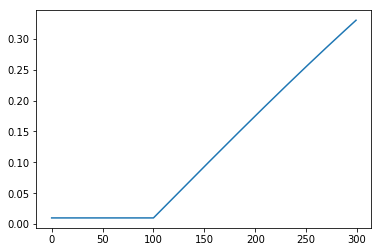

In [11]:
import matplotlib.pyplot as plt
import numpy as np , math
plt.plot([f_hp_decay(e) for e in range(epochs)])

In [34]:
def step_decay(epoch):
            
    lr0 = .00128437
    #print("learning rate , lr 0 ", lr, lr0)
    a = 1
    b = 4
    p = epoch/epochs
    lrate = lr0/math.pow((1+a*p),b)
    return lrate

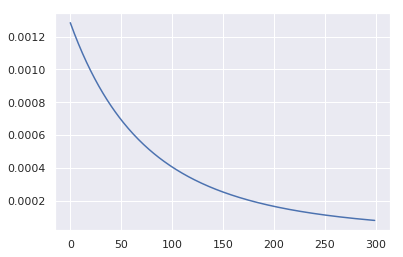

In [35]:
plt.plot([step_decay(e) for e in range(epochs)])